# Toxic Comment Classification

In this notebook, we'll be developing a model that can classify string comments based on their toxicity:
* `toxic`
* `severe_toxic`
* `obscene`
* `threat`
* `insult`
* `identity_hate`

This will be completed as part of the [Toxic Comment Classification](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge) Kaggle competition. From the site:

>In this competition, you’re challenged to build a multi-headed model that’s capable of detecting different types of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. You’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.

### Import Data

The data we'll be using consists of a large number of Wikipedia comments which have been labeled by humans according to their relative toxicity. The data can be found [here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data). Download the following and store in directory's data folder.
* `train.csv` - the training set, contains comments with their binary labels.
* `test.csv` - the test set, predict toxicity probabilities for these comments.
* `sample_submission.csv` - the submission sample with the correct format.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

# Import data
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
print('Dataset Loaded')

Dataset Loaded


### Explore Data

Let's extract our features and labels and take a look at the data.

In [2]:
# Extract comments
X_train = train["comment_text"].fillna("__NaNNaNNaN__").values
X_test = test["comment_text"].fillna("__NaNNaNNaN__").values

# Extract labels
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train[list_classes].values

# Sample from dataset
for sample_i in range(3):
    print('Comment #{}:  {}'.format(sample_i + 1, X_train[sample_i]))
    print('Label #{}:    {}'.format(sample_i + 1, y_train[sample_i]))

Comment #1:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Label #1:    [0 0 0 0 0 0]
Comment #2:  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Label #2:    [0 0 0 0 0 0]
Comment #3:  Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.
Label #3:    [0 0 0 0 0 0]


In [3]:
# Explore vocabulary
import collections

# Create a counter object for each dataset
word_counter = collections.Counter([word for sentence in tqdm(X_train, total=len(X_train)) \
                                                              for word in sentence.split()])

print('{} words.'.format(len([word for sentence in X_train for word in sentence.split()])))
print('{} unique words.'.format(len(word_counter)))
print('10 Most common words in the dataset:')
print('"' + '" "'.join(list(zip(*word_counter.most_common(10)))[0]) + '"')

100%|██████████████████████████████████████████████████████████████████████| 159571/159571 [00:01<00:00, 116765.37it/s]  6%|████▌                                                                  | 10188/159571 [00:00<00:01, 101778.67it/s]


10734904 words.
532299 unique words.
10 Most common words in the dataset:
"the" "to" "of" "and" "a" "I" "is" "you" "that" "in"


Our data contains 10,734,904 words, 532,299 of which are unique, and the 10 most common being: "the", "to", "of", "and", "a", "I", "is", "you", "that", and "in". For comparison, the oxford english dictionary contains 171,476 full entries. One problem here is that we are counting uppercase words as different from lower case words and a bunch of other symbols that aren't really useful for our goal. We will clean this up in the next step.

### Preprocess Data

Before continuing, we'll have to preprocess our data a bit so that it's in a format we can input into a neural network. Let's:

1. Remove irrelevant characters (```!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n```).
2. Convert all letters to lowercase (HeLlO -> hello).
3. Tokenize our words (hi how are you -> [23, 1, 5, 13]).
4. Standaridize our input length with padding (hi how are you -> [23, 1, 5, 13, 0, 0, 0]).

We can go further and consider combining misspelled, slang, or different word inflections into single base words. However, the benefit of using a neural network is that they do well with raw input, so we'll stick with what we have listed.

In [4]:
# Tokenize and Pad
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Create tokenizer
tokenizer = Tokenizer(num_words=None,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                      lower=True,
                      split=" ",
                      char_level=False)

# Fit and run tokenizer
tokenizer.fit_on_texts(list(X_train))
tokenized_train = tokenizer.texts_to_sequences(X_train)
tokenized_test = tokenizer.texts_to_sequences(X_test)
word_index = tokenizer.word_index

# Extract variables
vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))
longest = max(len(seq) for seq in tokenized_train)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in tokenized_train])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in tokenized_train])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print('Max comment size: {}'.format(max_len))
print()

# Pad sequences
processed_X_train = pad_sequences(tokenized_train, maxlen=max_len, padding='post', truncating='post')
processed_X_test = pad_sequences(tokenized_test, maxlen=max_len, padding='post', truncating='post')

# Sample tokenization
for sample_i, (sent, token_sent) in enumerate(zip(X_train[:2], tokenized_train[:2])):
    print('Sequence {}'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

C:\Anaconda2\envs\aind\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Vocab size: 210337
Longest comment size: 1403
Average comment size: 68.22156908210138
Stdev of comment size: 101.07344657013672
Max comment size: 371

Sequence 1
  Input:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
  Output: [688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]
Sequence 2
  Input:  D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
  Output: [96145, 52, 2635, 13, 555, 3809, 73, 4556, 2706, 21, 94, 38, 803, 2679, 992, 589, 8377, 182]


After preprocessing, our vocabulary size drops to a more manageable 210,337.

### Embedding

The most obvious data representation for our vocabulary is one-hot encoding where every word is transformed into a vector with a 1 in its corresponding location. For example, if our word vector is [hi, how, are, you] and the word we are looking at is "you", the input vector for "you" would just be [0, 0, 0, 1]. This works fine unless our vocabulary is huge - in this case, 210,000 - which means we would end up with word vectors that consist mainly of a bunch of 0s.

Instead, we can use a Word2Vec technique to find continuous embeddings for our words. Here, we'll be using the pretrained [FastText embeddings](https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md) from Facebook to produce a 300-dimension vector for each word in our vocabulary.
* P. Bojanowski, E. Grave, A. Joulin, T. Mikolov, [Enriching Word Vectors with Subword Information](https://arxiv.org/abs/1607.04606)

The benefit of this continuous embedding is that words with similar predictive power will appear closer together on our word vector. The downside is that this creates more of a black box where the words with the most predictive power get lost in the numbers.

*Note: update path to where embedding download is stored.*

In [5]:
embedding_dim = 300

# Get embeddings matrix
embeddings_index = {}
f = open('X:\\utility_data\\wiki.en.vec', encoding="utf8")
for line in f:
    values = line.rstrip().rsplit(' ', embedding_dim)
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found {} word vectors.'.format(len(embeddings_index)))

Found 2519371 word vectors.


In [6]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

This process takes a while so we should save our output to disk.

In [7]:
# Save embeddings
import h5py
with h5py.File('./data/embeddings.h5', 'w') as hf:
    hf.create_dataset("fasttext",  data=embedding_matrix)

In [8]:
# Load embeddings
with h5py.File('./data/embeddings.h5', 'r') as hf:
    embedding_matrix = hf['fasttext'][:]

### Modeling

Now that our data is preprocessed and our embeddings are ready, let's build a model. For learning purposes, we'll build a neural network architecture that is more complicated than it needs to be. We'll build an:

1. Embedding layer - word vector representations.
2. Bidirectional GRU layer - extract temporal data such as words that came before and after current word.
3. Convolutional layer - run multiple filters over that temporal data.
4. Fully connected layer - classify input based on filters.

The idea is that our GRU recurrent layer will find temporal data that it passes to our Convolutional layer where filters will be learned to detect toxicity.

In [9]:
import keras.backend
from keras.models import Sequential
from keras.layers import CuDNNGRU, Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Nadam

# Initate model
model = Sequential()

# Add Embedding layer
model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix],
                    input_length=max_len, trainable=True))

# Add Recurrent layers
model.add(Bidirectional(CuDNNGRU(300, return_sequences=True)))

# Add Convolutional layer
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(3))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

# Add fully connected layers
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='sigmoid'))

# Summarize the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 371, 300)          63101400  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 371, 600)          1083600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 371, 128)          384128    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 123, 128)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6450      
__________

### Compile the model
We'll be using binary crossentropy as our loss function and clipping our gradients to avoid any explosions.

In [10]:
def loss(y_true, y_pred):
     return keras.backend.binary_crossentropy(y_true, y_pred)

lr = .0001
model.compile(loss=loss, optimizer=Nadam(lr=lr, clipnorm=1.0),
              metrics=['binary_accuracy'])

### Metric

To evaluate our model, we'll be looking at its AUC ROC score (area under the receiver operating characteristic curve). This is a fancy way to say we will be looking at the probability that our model ranks a randomly chosen positive instance higher than a randomly chosen negative one. With data that mostly consists of negative labels (no toxicity), our model could just learn to always predict negative and end up with a pretty high accuracy. AUC ROC helps correct this by putting more weight on the the positive examples.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

class RocAucEvaluation(Callback):
    def __init__(self, filepath, validation_data=(), interval=1, max_epoch = 100):
        super(Callback, self).__init__()

        self.interval = interval
        self.filepath = filepath
        self.stopped_epoch = max_epoch
        self.best = 0
        self.X_val, self.y_val = validation_data
        self.y_pred = np.zeros(self.y_val.shape)

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict_proba(self.X_val, verbose=0)
            current = roc_auc_score(self.y_val, y_pred)
            logs['roc_auc_val'] = current

            if current > self.best: #save model
                print(" - AUC - improved from {:.5f} to {:.5f}".format(self.best, current))
                self.best = current
                self.y_pred = y_pred
                self.stopped_epoch = epoch+1
                self.model.save(self.filepath, overwrite=True)
            else:
                print(" - AUC - did not improve")
            
[X, X_val, y, y_val] = train_test_split(processed_X_train, y_train, test_size=0.03, shuffle=False)
RocAuc = RocAucEvaluation(filepath='./saved_models/model.best.hdf5',validation_data=(X_val, y_val), interval=1)

### Train the model

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Set variables
batch_size = 64
epochs = 100

# Set early stopping
early_stop = EarlyStopping(monitor="roc_auc_val", mode="max", patience=2)
                                                    
# Train
graph = model.fit(X, y, batch_size=batch_size, epochs=epochs,
                  validation_data=(X_val, y_val), callbacks=[RocAuc, early_stop],
                  verbose=2, shuffle=False)

Train on 154783 samples, validate on 4788 samples
Epoch 1/100
 - AUC - improved from 0.00000 to 0.97720
 - 467s - loss: 0.1170 - binary_accuracy: 0.9588 - val_loss: 0.0478 - val_binary_accuracy: 0.9821
Epoch 2/100
 - AUC - improved from 0.97720 to 0.98145
 - 464s - loss: 0.0530 - binary_accuracy: 0.9813 - val_loss: 0.0443 - val_binary_accuracy: 0.9831
Epoch 3/100
 - AUC - improved from 0.98145 to 0.98266
 - 464s - loss: 0.0446 - binary_accuracy: 0.9834 - val_loss: 0.0474 - val_binary_accuracy: 0.9814
Epoch 4/100
 - AUC - improved from 0.98266 to 0.98426
 - 466s - loss: 0.0386 - binary_accuracy: 0.9850 - val_loss: 0.0444 - val_binary_accuracy: 0.9834
Epoch 5/100
 - AUC - did not improve
 - 461s - loss: 0.0339 - binary_accuracy: 0.9866 - val_loss: 0.0466 - val_binary_accuracy: 0.9823
Epoch 6/100
 - AUC - did not improve
 - 461s - loss: 0.0293 - binary_accuracy: 0.9883 - val_loss: 0.0469 - val_binary_accuracy: 0.9826


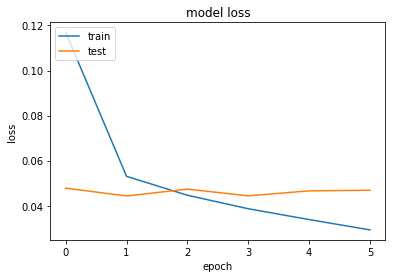

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# Visualize history of loss
plt.plot(graph.history['loss'])
plt.plot(graph.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

After training our model, we end up with an AUC ROC score of 98.26%. Not bad for a first run. To do even better we can:

* Add more layers.
* Experiment with different dropout and normalization techniques.
* Experiment with different layers and parameters.
* Experiment with cleaning the data more (translation, label adjustments, etc).

### Load best weights and predict

In [14]:
model.load_weights('./saved_models/model.best.hdf5')

In [15]:
predictions = model.predict(processed_X_test, verbose=0)

### Format for Kaggle submission

In [16]:
sample_submission = pd.read_csv("./data/sample_submission.csv")
sample_submission[list_classes] = predictions
sample_submission.to_csv("./data/submission1.csv", index=False)

### Create an App for prediction
Finally, let's build an app pipeline that can be put into production for toxic comment classification. It will take in a string and return the odds that it is any one of the toxic classifications.

In [17]:
def toxicity_level(string):
    """
    Return toxicity probability based on inputed string.
    """
    # Process string
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string)
    new_string = pad_sequences(new_string, maxlen=max_len, padding='post', truncating='post')
    
    # Predict
    prediction = model.predict(new_string)
    
    # Print output
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

toxicity_level('go jump off a bridge jerk')
toxicity_level('i will kill you')
toxicity_level('have a nice day')
toxicity_level('hola, como estas')
toxicity_level('hola mierda joder')

Toxicity levels for 'go jump off a bridge jerk':
Toxic:         99%
Severe Toxic:  12%
Obscene:       91%
Threat:        2%
Insult:        93%
Identity Hate: 4%

Toxicity levels for 'i will kill you':
Toxic:         87%
Severe Toxic:  8%
Obscene:       41%
Threat:        63%
Insult:        59%
Identity Hate: 12%

Toxicity levels for 'have a nice day':
Toxic:         0%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%

Toxicity levels for 'hola, como estas':
Toxic:         0%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%

Toxicity levels for 'hola mierda joder':
Toxic:         16%
Severe Toxic:  0%
Obscene:       9%
Threat:        0%
Insult:        1%
Identity Hate: 0%

